# Demo Code

This Jupyter Notebook is a fully runnable demo version of the imputation code. Please refer to the paper for more detailed information.

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import argparse
import csv
import warnings
import torch
import random
from scipy.stats import spearmanr
from autograd_minimize import minimize
from statsmodels.stats.multitest import multipletests

## Initialize Variables/Directories/Files

In [2]:
# Random seed
seed = 42
# Input data directory
data_dir = "demo_data"
# Results directory
results_dir = "demo_results"
# Number of embedding dimensions for NMF
n_dims = 30
# Whether or not cross validation is enabled
cv = False
# Number of cross validation folds
cv_folds = 10
# Options for embedding dimension
n_dims_options = np.arange(start=15, stop=35, step=5)
# Write embedding matrices to .csv files
verbose_embeddings = False
# Number of repeated trials at each test proportion
n_iter = 10
# Whether or not TIC normalization is enabled
normalize = True
# Which dataset is the target dataset? (e.g. [1,0,0]=first dataset)
proportions = [1,0,0]
# Options for feature test propotion iteration
f_test_prop_options = [0.1,0.3,0.1]
# Range of dimensions to evaluate in cross validation
cv_dims = [15, 35, 5]

In [3]:
raw_data_dir = f'{data_dir}/raw'
plots_dir = f'{results_dir}/plots'
try:
    os.makedirs("demo_results")
except OSError as error:
    print(error)

# initialize CSV files for storing cross validation results
# and errors/scores for each pair of regularization parameters
if cv:
    n_dims = None
    out_header = ["feature_test_prop_pct","n_dims"]
    with open(f'{results_dir}/cv_dims.csv','w') as file:
        writer = csv.writer(file)
        writer.writerow(out_header)
    out_header = ["feature_test_prop_pct","n_dims","fold","mae"]
    with open(f'{results_dir}/cv_folds_scores.csv','w') as file:
        writer = csv.writer(file)
        writer.writerow(out_header)

[WinError 183] Cannot create a file when that file already exists: 'demo_results'


## Functions

### Load data

For this demo, we use a subset of the 9 datasets we used for our paper in order to decrease the runtime.

In [4]:
def load_data():
    '''
    This function loads the raw metabolomics data and puts it in a single data
    matrix (samples/features).
    
    Inputs: None
    
    Outputs:
        data: samples by features data matrix
        batch_index_vector: list of which batch each sample comes from
        feature_map
        sample_map
        batch_map
        s_test_prop_settings: DataFrame of how many samples are reserved for testing
    '''
    features = set()
    nrows = 0
    samples = []
    batch_names = []
    for batch_idx, fpath in enumerate(os.listdir(raw_data_dir)):
        if 'csv' not in fpath:
            continue
        df = pd.read_csv(f'{raw_data_dir}/{fpath}', header=0, index_col=0).T
        features.update(df.columns)
        samples.extend(df.index)
        batch_names.append(fpath)
        nrows += df.shape[0]
    feature_map = {s:i for i,s in enumerate(features)}
    sample_map = {s:i for i,s in enumerate(samples)}
    batch_map = {s:i for i,s in enumerate(batch_names)}
    data = np.full((nrows, len(features)), np.nan)
    batch_index_vector = np.zeros(nrows, dtype=int) 
    sidx = 0
    batch_idx = 0
    for fpath in os.listdir(f'{raw_data_dir}'):
        if 'csv' not in fpath:
            continue
        df = pd.read_csv(f'{raw_data_dir}/{fpath}', header=0, index_col=0).T
        for feature in df.columns:
            fidx = feature_map[feature]
            data[sidx:sidx+df.shape[0], fidx] = df[feature].values
        batch_index_vector[sidx:sidx+df.shape[0]] = batch_idx
        sidx += df.shape[0]
        batch_idx += 1
    s_test_prop_settings = pd.DataFrame(list(zip(batch_names, proportions)), columns=["batches", "s_test_prop"])
    return data, batch_index_vector, feature_map, sample_map, batch_map, s_test_prop_settings

### Pre-processing

Please refer to Methods section 2 of the paper for detailed information about the following functions.

In [5]:
def tic_normalization(data,batch_index_vector):
    '''
    Normalization function where present values are divided by the sum of
    the row. Left-censored data is considered as 1/2 the lowest measured
    value in the batch, but is not filled in until the rank-conversion occurs.
    
    Inputs:
        data: samples by features data matrix
        batch_index_vector: list of which batch each sample comes from
        
    Outputs:
        data: normalized input data
    '''
    normalized_data = np.copy(data)
    n_batches = batch_index_vector.max()+1
    for bidx in range(n_batches):
        batch_rows = np.arange(data.shape[0])[batch_index_vector == bidx]
        batch = data[batch_rows]
        nan_mask = np.isnan(batch)
        missing = np.all(nan_mask, axis=0)
        min_batch = np.nanmin(batch)
        for row in range(batch.shape[0]):
            n_censored = np.sum(nan_mask[row])-np.sum(missing)
            row_tic = np.nansum(batch[row]) + 0.5 * n_censored * min_batch
            batch[row,:] = batch[row,:]/row_tic
        batch = batch / np.nansum(batch, axis=1, keepdims=True)
        normalized_data[batch_rows] = batch
    return normalized_data


def convert_to_ranks(data, batch_index_vector):
    '''
    This function converts data to ranks as a form of normalization. The samples
    are ranked in each feature by their count, then divided by the total number
    of samples for that feature. Censored samples are tied for last by setting
    their rank equal to halfway between the minimum possible rank and the rest
    of the ranks of non-missing values.
    (ex: for a single feature, if sample93 has the highest count (100), sample167
    has the next highest count (80), and sample36 has the third highest count (45), and
    sample45 and sample16 are censored, the rank will be computed as follows:
    First, the samples are mapped to numbers which give them rank in ascending
    order from least to greatest in the list (pretty much a rank). Censored values
    are tied for last in this step
    Sample93: 6, sample167:5, sample36:4, sample45: 3, sample16: 3.
    These ranks are then normalized by the number of samples (everything is
    divided by the number of samples plus one). This maps the samples uniformly
    from 0 to 1. The rank of the censored values are also divided by 2 so that
    their rank is halfway between the minimum possible rank and the next highest rank.
    Sample93: 6/6, sample167:5/6, sample36:4/6, sample45: 3/6/2, sample16: 3/6/2.
    Sample93: 1, sample167:0.83, sample36:0.66, sample45: 0.25, sample16: 0.25.

    This ranking method allows comparison across batches because they features
    now have identical uniform distributions.
    The ranks are what are imputed and scored on.
    
    Inputs:
        data: samples by features data matrix
        batch_index_vector: list of which batch each sample comes from
    
    Outputs:
        data: normalized input data
    '''
    n_batches = batch_index_vector.max()+1
    for bidx in range(n_batches):
        batch_rows = np.arange(data.shape[0])[batch_index_vector == bidx]
        batch = data[batch_rows]
        missing = np.all(np.isnan(batch), axis=0)
        for col in range(data.shape[1]):
            if missing[col]:
                continue
            missing_in_col = np.isnan(batch[:,col])
            rows = batch_rows[~missing_in_col]
            vals = data[rows, col]
            normalizer = len(batch)+1
            order = vals.argsort()
            data[rows[order], col] = np.arange(missing_in_col.sum()+1,1+len(batch)) / normalizer
            data[batch_rows[missing_in_col], col] = (missing_in_col.sum()+1) * 0.5 / normalizer
    return data

### Cross Validation

Please refer to Methods section 5 of the paper for detailed information about the following functions.

In [6]:
def split_folds(data, batch_index_vector, n_folds):
    '''
    This function splits the data into folds for cross-validation. If running
    the nmf on only a single batch, half the samples are used for cross
    valdidation (the other half is used for testing). Otherwise, all samples
    could be used since there will be another batch to test on.
    The code isolates a batch, determines features available to use, splits up
    the available features into folds (as many as are specified by n_folds),
    and then selects samples to complete the fold.
    
    Inputs:
        data: samples by features data matrix
        batch_index_vector: list of which batch each sample comes from
        n_folds: number of folds to split data into
    
    Outputs:
        folds: split data for cross validation
    '''
    n_batches = batch_index_vector.max()+1
    folds = [[] for _ in range(n_folds)]
    if n_batches.max() == 1:
        cv_sample_prop = 0.5
    else:
        cv_sample_prop = 1
    for bidx in range(n_batches):
        batch = data[batch_index_vector == bidx]
        missing = np.any(np.isnan(batch), axis=0)
        solo = np.all(np.isnan(data[batch_index_vector != bidx]), axis=0)
        if n_batches.max() == 1:
            solo = ~solo
        available = np.arange(batch.shape[1])[(~missing) & (~solo)]
        np.random.shuffle(available)
        splits = np.array_split(available, n_folds)
        rows = np.arange(data.shape[0])[batch_index_vector == bidx]
        for fold_idx in range(n_folds):
            cols = splits[fold_idx]
            for cidx in cols:
                random_rows = np.random.choice(rows,size=round(batch.shape[0]*cv_sample_prop),replace=False)
                folds[fold_idx].extend([[x, cidx] for x in random_rows])
    folds = [np.array(fold) for fold in folds]
    return folds


def cross_validation(training, batch_index_vector, n_folds):
    '''
    This function executes cross validation on the training data to determine the
    optimal number of embedding dimensions and the value of the regularization parameters.
    
    Inputs:
        training
        batch_index_vector: list of which batch each sample comes from
        n_folds
    
    Outputs:
        n_dims: optimal int of embedding dimensions
    '''
    folds = split_folds(training, batch_index_vector,n_folds)
    n_dims_options = np.arange(start=cv_dims[0], stop=cv_dims[1], step=cv_dims[2])
    scores = np.zeros((len(n_dims_options), n_folds))
    for didx, n_dims in enumerate(n_dims_options):
        for fidx, fold in enumerate(folds):
            cv_training = np.copy(training)
            cv_training[fold[:,0], fold[:,1]] = np.nan
            W, H = nmf(training, n_dims)
            X = W@H
            X_ranks = convert_to_ranks(X,batch_index_vector)
            scores[didx, fidx] = np.abs(X_ranks[fold[:,0], fold[:,1]] - training[fold[:,0], fold[:,1]]).mean()
            with open(f'{results_dir}/cv_folds_scores.csv','a') as file:
                writer = csv.writer(file)
                writer.writerow([feature_test_prop,n_dims,fidx,scores[didx, fidx]])
    n_dims = n_dims_options[np.argmin(scores.mean(axis=1))]
    print(f'Best dims is {n_dims}')
    return n_dims

### Holding out data to assess prediction

Please refer to Methods section 6 of the paper for detailed information about the following functions.

In [7]:
def test_train_split(data,batch_index_vector,batch_map,s_test_prop_settings,f_test_prop=0.1):
    '''
    This function splits the data into testing and training data for both samples and features.
    To select the samples for testing: The function takes the entire data matrix,
    singles out one batch at a time, randomly selects a proportion of the samples
    according to the sample test proportions input file (the samples selected for
    testing can be changed depening on which batch you're looking at), adds
    their indices to a list of test samples.
    To select the features for testing: The proportion of features for testing
    is set to be 0.1 (but this can be changed). Features must be selected so that
    they are present in the data (after they and the testing samples are held out)
    so that there is data available to be tested against. [Also considered were sparse
    features, meaning they weren't all NaN but there were very few data points to test on.
    
    Inputs:
        data: samples by features data matrix
        batch_index_vector: list of which batch each sample comes from
        batch_map
        s_test_prop_settings: DataFrame of how many samples are reserved for testing
        f_test_prop
    
    Outputs:
        training: data to be used for training
        testing: data to be used for testing
        test_sample_indices: list of indices of samples held out for testing
        test_feature_indices: list of indices of features held out for testing
    '''
    test_sample_indices = []
    ridx = 0
    for bidx, bname in enumerate(batch_map):
        batch_s_test_prop_row = s_test_prop_settings[s_test_prop_settings["batches"] == bname]
        batch_s_test_prop = float(batch_s_test_prop_row.iloc[:,1].to_numpy())
        n_rows_in_batch = np.sum(batch_index_vector == bidx)
        available_samples = np.arange(ridx,ridx+n_rows_in_batch)
        test_sample_indices.extend(np.random.choice(a=available_samples,size=round(batch_s_test_prop*len(available_samples)),replace=False))
        ridx += n_rows_in_batch
    sample_masked_data = np.copy(data)
    sample_masked_data[test_sample_indices,:] = np.nan
    solo = np.all(np.isnan(sample_masked_data), axis=0)
    missing = np.all(np.isnan(data[test_sample_indices,:]), axis=0)
    available_features = np.arange(data.shape[1])[(~missing) & (~solo)]
    test_feature_indices = np.random.choice(available_features,size=int(round(f_test_prop*len(available_features))), replace=False)
    training = np.copy(data)
    testing = np.full(data.shape,np.nan)
    for sidx in test_sample_indices:
        for fidx in test_feature_indices:
            training[sidx,fidx] = np.nan
            testing[sidx,fidx] = data[sidx,fidx]
    return training, testing, test_sample_indices, test_feature_indices

def testing_function(ranked_predictions, training, testing, test_sample_indices, test_feature_indices, feature_map, sample_map, plotnum='', ve=False, fsuffix=''):
    '''
    This function tests the model's performance on the testing data.
    
    Inputs:
        ranked_predictions
        training
        testing
        test_sample_indices
        test_feature_indices
        feature_map
        sample_map
        plotnum
        ve
        fsuffix
    
    Outputs:
        actual_pred_df: DataFrame of actual and predicted values
    '''
    
    feature_vec = []
    actual_pred_df = pd.DataFrame({'actual_rank':[],'predicted_rank':[],'feature':[], 'sample_index':[]})
    for fidx in test_feature_indices:
        actual_vec = []
        predicted_vec = []
        for sidx in test_sample_indices:
            actual = testing[sidx,fidx]
            predicted = ranked_predictions[sidx,fidx]
            actual_vec.append(actual)
            predicted_vec.append(predicted)
        current_feature = list(feature_map)[fidx]
        feature_vec.append(current_feature)
        actual_pred_df_feature = pd.DataFrame({'actual_rank':actual_vec,'predicted_rank':predicted_vec})
        actual_pred_df_feature['feature'] = current_feature
        actual_pred_df_feature['sample_index'] = test_sample_indices
        actual_pred_df = pd.concat([actual_pred_df,actual_pred_df_feature])
        
    return actual_pred_df


### NMF

Please refer to Methods section 4 of the paper for detailed information about the following functions.

In [8]:
def save_embedding(matrix,mapping,mode):
    '''
    This function saves the embedding matrices (either the features matrix H
    or the samples matrix W) to a csv file. The features/samples are labeled
    so that enrichment tests on the embedding vectors are possible.
    
    Inputs:
        matrix
        mapping
        mode
    
    Outputs: None
    '''
    if mode == "features":
        features_from_index = {v: k for k, v in mapping.items()}
        feature_names = [features_from_index[i] for i in range(len(mapping))]
        dim_lab_num = np.arange(start=1,stop=matrix.shape[0]+1)
        pd.DataFrame(matrix, index=dim_lab_num, columns=feature_names).to_csv(f'{results_dir}/nmf_matrix_H_{int(feature_test_prop*100)}_pct.csv')
    elif mode == "samples":
        samples_from_index = {v: k for k, v in mapping.items()}
        sample_names = [samples_from_index[i] for i in range(len(mapping))]
        dim_lab_num = np.arange(start=1,stop=matrix.shape[1]+1)
        pd.DataFrame(matrix, index=sample_names, columns=dim_lab_num).to_csv(f'{results_dir}/nmf_matrix_W_{int(feature_test_prop*100)}_pct.csv')


def nmf(X, n_dims=10):
    '''
    This function does non-negative matrix factorization.
    
    Inputs:
        X: training data
        n_dims: number of dimensions
    
    Outputs:
        W: samples (coefficients) matrix (rows are samples, columns are dims)
        H: features matrix (rows are dims, columns are features)
    '''
    n_samples, n_features = X.shape
    x0 = {'W': np.random.random(size = (n_samples,n_dims)), 'H': np.random.random(size = (n_dims,n_features))}
    t_X = torch.Tensor(X)
    def nmf_loss(W=None, H=None):
        out = torch.matmul(W,H)
        nan = torch.isnan(t_X)
        y = torch.where(nan, torch.tensor(0.0), t_X)
        out = torch.where(nan, torch.tensor(0.0), out)
        L = torch.sum((out - y) ** 2)
        return L
    res = minimize(nmf_loss,x0, method='L-BFGS-B', bounds=(0, None), backend='torch')
    W = res.x['W']
    H = res.x['H']
    return W, H


def run_nmf(training, testing, test_sample_indices, test_feature_indices, feature_map, sample_map, plotnum='', n_folds=50, n_dims=22, ve=False, fsuffix=""):
    '''
    This function runs the nmf function.
    
    Inputs:
        training
        testing
        test_sample_indices
        test_feature_indices
        feature_map
        sample_map
        plotnum
        n_folds
        n_dims
        ve
        fsuffix
    
    Outputs:
        median_R_sq
        total_r_sq
        actual_pred_df
        n_dims
    '''
    if n_dims is None:
        n_dims = cross_validation(training, batch_index_vector, n_folds)
    W, H = nmf(training, n_dims)
    X_predictions = W@H
    ranked_predictions = convert_to_ranks(X_predictions,batch_index_vector)
    
    if ve:
        save_embedding(H,feature_map,"features")
        save_embedding(W,sample_map,"samples")
        
    actual_pred_df = testing_function(ranked_predictions, training, testing, test_sample_indices, test_feature_indices, feature_map, sample_map, plotnum=i, ve=False, fsuffix="")
    return actual_pred_df, n_dims

## Experiment

These cells execute the above functions to perform a MIRTH imputation benchmarking experiment across datasets. Actual and predicted ranks are obtained for visualization in the following section.

In [9]:
# Set seed so there is not too much variance in trials
np.random.seed(seed)

# Load and preprocess data
data, batch_index_vector, feature_map, sample_map, batch_map, s_test_prop_settings = load_data()
pd.DataFrame(feature_map.items(), columns=['feature_name','feature_index']).to_csv(f'{results_dir}/feature_map.csv')
pd.DataFrame(sample_map.items(), columns=['sample_name','sample_index']).to_csv(f'{results_dir}/sample_map.csv')
pd.DataFrame(batch_map.items(), columns=['batch_name','batch_index']).to_csv(f'{results_dir}/batch_map.csv')
features_from_index = {v: k for k, v in feature_map.items()}
feature_names = [features_from_index[i] for i in range(len(feature_map))]
samples_from_index = {v: k for k, v in sample_map.items()}
sample_names = [samples_from_index[i] for i in range(len(sample_map))]
pd.DataFrame(data, index=sample_names, columns=feature_names).to_csv(f'{results_dir}/raw_data_compiled.csv')
if normalize:
    data = tic_normalization(data,batch_index_vector)
    pd.DataFrame(data, index=sample_names, columns=feature_names).to_csv(f'{results_dir}/normalized_data.csv')
ranked_data = convert_to_ranks(data, batch_index_vector)

In [10]:
# Initialize results DataFrames. If cross-validation is enabled, initialize
# a CSV file to store the best n_dims for each feature test proportion.
actual_pred_res_df = pd.DataFrame({'actual_rank':[],'predicted_rank':[],'feature':[],'sample_index':[],'iteration':[], 'f_test_prop':[]})

if cv:
    out_header = ["feature_test_prop_pct","n_dims"]
    with open(f'{results_dir}/cv_dims.csv','w') as file:
        writer = csv.writer(file)
        writer.writerow(out_header)

# Loop through feature test proportions to create actual vs predicted results DataFrame
for feature_test_prop in np.arange(f_test_prop_options[0],f_test_prop_options[1],f_test_prop_options[2]):
    print(f'Holding out {int(feature_test_prop*100)}% of features from the target dataset')
    for i in range(n_iter):
        print(f'\tIteration {i+1}/{n_iter}')
        training, testing, test_sample_indices, test_feature_indices = test_train_split(ranked_data,batch_index_vector,batch_map,s_test_prop_settings,f_test_prop=feature_test_prop)
        actual_pred_df, n_dims = run_nmf(training, testing, test_sample_indices, test_feature_indices, feature_map, sample_map, plotnum=i, n_folds=cv_folds, n_dims=n_dims, ve=verbose_embeddings)
        actual_pred_df['iteration'] = i
        actual_pred_df['f_test_prop'] = feature_test_prop
        actual_pred_res_df = pd.concat([actual_pred_res_df,actual_pred_df])
    if cv:
        with open(f'{results_dir}/cv_dims.csv','a') as file:
            writer = csv.writer(file)
            writer.writerow([int(feature_test_prop*100),n_dims])
        n_dims = None

# Write results to CSV
# actual_pred_res_df.to_csv(f'{results_dir}/actual_vs_predicted_ranks.csv')


Holding out 10% of features from the target dataset
	Iteration 1/10
	Iteration 2/10
	Iteration 3/10
	Iteration 4/10
	Iteration 5/10
	Iteration 6/10
	Iteration 7/10
	Iteration 8/10
	Iteration 9/10
	Iteration 10/10
Holding out 20% of features from the target dataset
	Iteration 1/10
	Iteration 2/10
	Iteration 3/10
	Iteration 4/10
	Iteration 5/10
	Iteration 6/10
	Iteration 7/10
	Iteration 8/10
	Iteration 9/10
	Iteration 10/10


## Plots

In [11]:
# Calculate rho and p-values
cor = actual_pred_res_df.groupby(["f_test_prop","iteration","feature"])[['actual_rank','predicted_rank']].corr(method='spearman').iloc[0::2,-1].to_frame()
pval = actual_pred_res_df.groupby(["f_test_prop","iteration","feature"])[['actual_rank','predicted_rank']].corr(method=lambda x, y: spearmanr(x, y)[1]).iloc[0::2,-1].to_frame()

# quick wrapper for multiple-testing correction
def correct_for_mult(data):
    data['p_adj'] = multipletests(pvals=data['pval'],method="fdr_bh",alpha=0.05)[1]
    return data

# obtain rho for each feature in each iteration
by_iter_rho = (pd.merge(cor.rename(columns={"predicted_rank": "rho"}),
                        pval.rename(columns={"predicted_rank": "pval"}),
                        how='left',
                        on=['f_test_prop','iteration','feature'])
               .groupby(["f_test_prop","iteration"], group_keys=False)
               .apply(correct_for_mult)
               # bin into significant/ns
               .assign(sig = lambda dataframe: dataframe['p_adj'].map(lambda p_adj: True if p_adj < 0.05 else False))
              )


# calculate median rho by iteration
# first, z-transform and group appropriately
g_median_by_iter = (by_iter_rho
                    .assign(z_score= lambda dataframe: dataframe['rho'].map(lambda rho: np.arctanh(rho)))
                    .groupby(["f_test_prop","iteration"], group_keys=False)
                   )

# compute median z-score and inverse z-transform to obtain median rho
median_rho_iter = (pd.DataFrame({"median_z": g_median_by_iter.median()['z_score'],
                                 "sig_in": g_median_by_iter.sum()['sig']/g_median_by_iter.size()})
                   .assign(median_rho = lambda dataframe: dataframe['median_z'].map(lambda z: np.tanh(z)))
)


# calculate median rho for each feature
# once again, z-transform and group appropriately
g_median_by_feature = (by_iter_rho
                       .assign(z_score= lambda dataframe: dataframe['rho'].map(lambda rho: np.arctanh(rho)))
                       .groupby(["f_test_prop","feature"], group_keys=False))

# compute median z-score and inverse z-transform to obtain median rho
median_rho_feature = (pd.DataFrame({"median_z": g_median_by_feature.median()['z_score'],
                                    "sig_in": g_median_by_feature.sum()['sig']/g_median_by_feature.size()})
                      .assign(median_rho = lambda dataframe: dataframe['median_z'].map(lambda z: np.tanh(z)))
                      # flag well-predicted metabolites 
                      .assign(sig_in_most = (lambda dataframe: dataframe['sig_in']
                                                # note that if a flag for "well-predicted metabolite" is desired, a condition for positive rho must be added here 
                                                .map(lambda sig_in: True if sig_in > 0.90 else False)))
                      .reset_index()
)


The following box plot shows the median rho values of all the features in each iteration, separated by the proportion of available features simulated as missing in the target dataset.

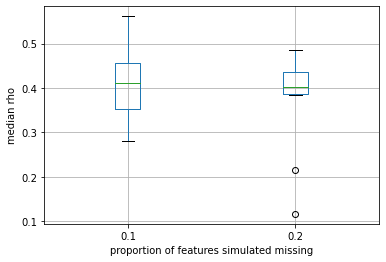

In [12]:
# Box plot
plt.rcParams['figure.figsize'] = [6, 4]
boxplot = (median_rho_iter
           .reset_index()
           .pivot(columns="f_test_prop",values="median_rho")
           .boxplot())
# plt.ylim([-1,1])
plt.ylabel('median rho')
plt.xlabel('proportion of features simulated missing')
plt.show()

The following bar plot shows the median rho values across all iterations for each metabolite when holding out 10% of the features from the testing set. The red bars indicate a significant correlation in greater than 90% of trials.

To see the figure more clearly, please open the image in a new tab and zoom in.

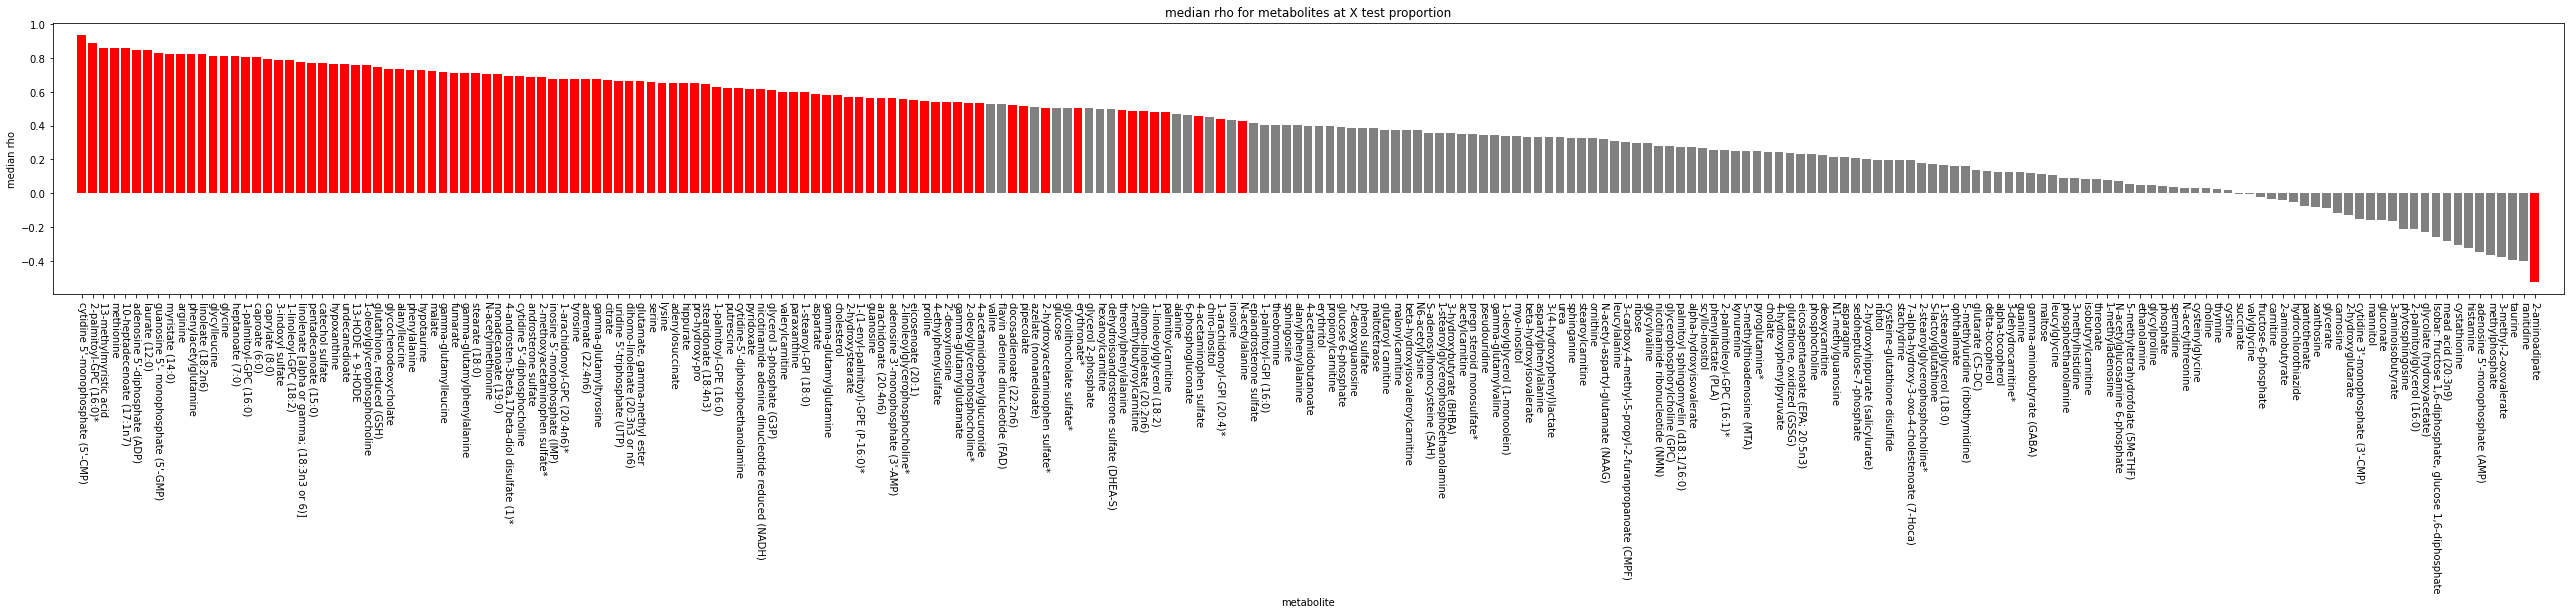

In [13]:
# Bar plot
# new dataframe filtered for smallest feature test proportion (usually 10%)

bar_df = (median_rho_feature[median_rho_feature["f_test_prop"] == min(median_rho_feature["f_test_prop"])]
    .sort_values(by=["median_rho"], ascending=False)
    .assign(color=lambda df: df['sig_in_most'].map(lambda wp: 'red' if wp else 'grey'))
    # FILTER FOR SMALLEST FEATURE TEST PROPORTION
)

plt.rcParams['figure.figsize'] = [45, 5]
plt.bar(bar_df["feature"], bar_df["median_rho"], color=bar_df["color"])
plt.xlabel("metabolite")
plt.ylabel("median rho")
plt.title("median rho for metabolites at X test proportion")
plt.xticks(rotation=-90)
plt.margins(x=0.01)
plt.show()

Please note that these results are for demonstration only - the well-predicted metabolites above should not be interpreted with high confidence due to the small number of trials in this experiment.